In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision einops tqdm pytorch-lightning scikit-learn
!git clone https://github.com/ucaswangls/EfficientSCI.git

import sys
sys.path.append("/content/EfficientSCI")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64,expandable_segments:True"

import re
import glob
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import gc
import random

from cacti.models.efficientsci import EfficientSCI

In [ ]:
# Configuration
do_train = True
do_eval = True
retrain = True
band = 1
model_ckpt_path = f"/content/drive/MyDrive/efficientSCI_finetuned_band{band}.pth"

train_locs = ['bos', 'bozeman', 'CarlinNev', 'la', 'dallas']
test_loc = 'miami'
patch_size = 44
grid_size = 2
batch_size = 1
epochs = 15


In [ ]:
class SCIBlockDataset(Dataset):
    def __init__(self, file_list, patch_size=100, grid_size=1):
        self.file_list = file_list
        self.patch_size = patch_size
        self.grid_size = grid_size
        self.patches_per_block = grid_size ** 2

    def __len__(self):
        return len(self.file_list) * self.patches_per_block

    def __getitem__(self, idx):
        block_idx = idx // self.patches_per_block
        patch_idx = idx % self.patches_per_block

        data = np.load(self.file_list[block_idx], mmap_mode = 'r')
        y = data['y']
        y = np.nan_to_num(y, nan=0.0)
        if np.isnan(y).any():
          print("NaN detected in y before conversion")
        phi = data['phi']
        x = data['x']
        x = np.nan_to_num(x, nan=0.0)
        phi_s = np.sum(phi, axis=0, keepdims=True) #shape [1, H, W]

        T, H, W = x.shape
        ps = self.patch_size

        row = (patch_idx // self.grid_size) * ps
        col = (patch_idx % self.grid_size) * ps

        y_patch = y[row:row+ps, col:col+ps]
        x_patch = x[:, row:row+ps, col:col+ps]
        phi_patch = phi[:, row:row+ps, col:col+ps].copy()


        phi_s = np.sum(phi[:, row:row+ps, col:col+ps], axis=0, keepdims=True)
        #Normalize the x and y patches

        max_val = np.max(x_patch) + 1e-8 #all bands
        x_patch = x_patch / max_val

        x_patch = np.clip(x_patch, a_min=0, a_max=None) #NOT BAND 1
        x_patch = np.log1p(x_patch) #NOT BAND 1

        y_patch = y_patch / max_val
        phi_patch = phi_patch/max_val

        phi_s = phi_s/max_val

        if np.sum(phi_patch) == 0:
          phi_patch = 1

        return (torch.tensor(y_patch).unsqueeze(0).float(), torch.tensor(phi_patch).float(), torch.tensor(phi_s).float(),torch.tensor(x_patch).float(), torch.tensor(max_val).float())

In [ ]:
all_files = sorted(glob.glob(f"/content/drive/MyDrive/Folder/data_blocks_2days/band_{band:02d}/*.npz"))

trainval_files = [f for f in all_files if test_loc not in os.path.basename(f)]
test_files = [f for f in all_files if test_loc in os.path.basename(f)]

train_files, val_files = train_test_split(trainval_files, test_size=0.2, random_state=42)

train_dataset = SCIBlockDataset(train_files, patch_size, grid_size)
val_dataset = SCIBlockDataset(val_files, patch_size, grid_size)
test_dataset = SCIBlockDataset(test_files, patch_size=100, grid_size=1)  # full patch

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16,shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientSCI().to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


EfficientSCI(
  (fem): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 1, 1), padding=(1, 3, 3))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (up_conv): Conv3d(256, 512, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (up): PixelShuffle(upscale_factor=2)
  (vrm): Sequential(
    (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv3d(128, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv3d(64, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (resdnet_list): ModuleList(
    (0-7): 8 x ResDNetBlock(
      (c

In [ ]:
def normalized_mse(x_pred, x_true, phi_s):
    return torch.sum((x_pred - x_true) ** 2) / (torch.sum(x_true ** 2) + 1e-8) #for all bands

def mixed_loss(pred, target, phi_s):
    nmse = normalized_mse(pred, target, phi_s)
    peak_weight = (target > 0.6).float() * 5.0 + 1.0  # Boost high-radiance pixels
    weighted_mse = torch.mean(peak_weight * (pred - target)**2)
    return nmse + weighted_mse

if do_train:

  train_losses, val_losses = [], []
  scaler = torch.cuda.amp.GradScaler()


  def run_training(epochs, lr, start_epoch=0):

      best_val = float('inf')
      best_state = None
      lr_decay_factor = 0.5

      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      early_stop_patience = 30
      no_improve_epochs = 0


      for epoch in range(start_epoch, start_epoch + epochs):

          torch.cuda.empty_cache()
          gc.collect()
          model.train()
          total_train_loss = 0

          for y, phi, phi_s, x, max_val in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            y, phi, phi_s, x = y.to(device), phi.to(device), phi_s.to(device), x.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():

                output = model(y, phi, phi_s)[0]
                output = torch.nan_to_num(output, nan=0.0)
                loss = mixed_loss(output, x, phi_s)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

          train_losses.append(total_train_loss / len(train_loader))

          # Validation
          model.eval()
          total_val_loss = 0
          with torch.no_grad():
              for y, phi, phi_s, x, max_val in val_loader:
                  y, phi, phi_s, x = y.to(device), phi.to(device), phi_s.to(device), x.to(device)
                  output = model(y, phi, phi_s)[0]
                  output = torch.nan_to_num(output, nan=0.0)
                  val_loss = mixed_loss(output, x, phi_s)
                  total_val_loss += val_loss.item()
                  if torch.isnan(output).any():
                      print("NaNs in model output!")

                  if torch.isnan(x).any():
                      print("NaNs in target x!")

          val_losses.append(total_val_loss / len(val_loader))
          # Save losses
          np.save("train_losses.npy", np.array(train_losses))
          np.save("val_losses.npy", np.array(val_losses))
          #scheduler.step(val_losses[-1])
          if val_losses[-1] < best_val:
            best_val = val_losses[-1]
            best_state = model.state_dict().copy()
            print(f'New Best Model at Epoch {epoch+1}')
            torch.save(best_state, model_ckpt_path)
            no_improve_epochs = 0

          else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs.")

          if (no_improve_epochs +1)% 20 ==0:
            for param_goup in optimizer.param_groups:
              param_group['lr'] *= lr_decay_factor

          if no_improve_epochs >= early_stop_patience:
            print('Early stopping occurred')
            break

          for param_group in optimizer.param_groups:
            print(f"[{epoch+1}] Train: {train_losses[-1]:.4f} | Val: {val_losses[-1]:.4f}| Learning rate: {param_group['lr']:.2e}")

          torch.cuda.empty_cache()
          gc.collect()

      return best_state, train_losses, val_losses

  # Main training
  if retrain:
    model.load_state_dict(torch.load(model_ckpt_path))
  best_model_state, train_losses, val_losses = run_training(epochs=200, lr=1e-5)

  # Save best model
  if best_model_state is not None:
    torch.save(best_model_state, model_ckpt_path)
    np.save("train_losses.npy", np.array(train_losses))
    np.save("val_losses.npy", np.array(val_losses))




/tmp/ipython-input-2271545570.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Train Epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-2271545570.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train Epoch 1: 100%|██████████| 800/800 [10:39<00:00,  1.25it/s]


New Best Model at Epoch 1
[1] Train: 0.1008 | Val: 0.1718| Learning rate: 1.00e-05


Train Epoch 2: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 1 epochs.
[2] Train: 0.1052 | Val: 0.1762| Learning rate: 1.00e-05


Train Epoch 3: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 2 epochs.
[3] Train: 0.1063 | Val: 0.1784| Learning rate: 1.00e-05


Train Epoch 4: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 4
[4] Train: 0.1013 | Val: 0.1702| Learning rate: 1.00e-05


Train Epoch 5: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 1 epochs.
[5] Train: 0.0990 | Val: 0.1733| Learning rate: 1.00e-05


Train Epoch 6: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 2 epochs.
[6] Train: 0.1027 | Val: 0.1806| Learning rate: 1.00e-05


Train Epoch 7: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 3 epochs.
[7] Train: 0.1048 | Val: 0.1822| Learning rate: 1.00e-05


Train Epoch 8: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 4 epochs.
[8] Train: 0.1021 | Val: 0.1727| Learning rate: 1.00e-05


Train Epoch 9: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 9
[9] Train: 0.0978 | Val: 0.1681| Learning rate: 1.00e-05


Train Epoch 10: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 1 epochs.
[10] Train: 0.0992 | Val: 0.1948| Learning rate: 1.00e-05


Train Epoch 11: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 2 epochs.
[11] Train: 0.1021 | Val: 0.1741| Learning rate: 1.00e-05


Train Epoch 12: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 3 epochs.
[12] Train: 0.1024 | Val: 0.1892| Learning rate: 1.00e-05


Train Epoch 13: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 4 epochs.
[13] Train: 0.1000 | Val: 0.1686| Learning rate: 1.00e-05


Train Epoch 14: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 5 epochs.
[14] Train: 0.0983 | Val: 0.1812| Learning rate: 1.00e-05


Train Epoch 15: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 6 epochs.
[15] Train: 0.0974 | Val: 0.1729| Learning rate: 1.00e-05


Train Epoch 16: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 7 epochs.
[16] Train: 0.0979 | Val: 0.1718| Learning rate: 1.00e-05


Train Epoch 17: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 8 epochs.
[17] Train: 0.0986 | Val: 0.1776| Learning rate: 1.00e-05


Train Epoch 18: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 9 epochs.
[18] Train: 0.0962 | Val: 0.1719| Learning rate: 1.00e-05


Train Epoch 19: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 10 epochs.
[19] Train: 0.0932 | Val: 0.1750| Learning rate: 1.00e-05


Train Epoch 20: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 11 epochs.
[20] Train: 0.0992 | Val: 0.1759| Learning rate: 1.00e-05


Train Epoch 21: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 12 epochs.
[21] Train: 0.0979 | Val: 0.1758| Learning rate: 1.00e-05


Train Epoch 22: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 13 epochs.
[22] Train: 0.0979 | Val: 0.1783| Learning rate: 1.00e-05


Train Epoch 23: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 14 epochs.
[23] Train: 0.0989 | Val: 0.1789| Learning rate: 1.00e-05


Train Epoch 24: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 15 epochs.
[24] Train: 0.0985 | Val: 0.1696| Learning rate: 1.00e-05


Train Epoch 25: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 16 epochs.
[25] Train: 0.0946 | Val: 0.1864| Learning rate: 1.00e-05


Train Epoch 26: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 17 epochs.
[26] Train: 0.0951 | Val: 0.1841| Learning rate: 1.00e-05


Train Epoch 27: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 18 epochs.
[27] Train: 0.0981 | Val: 0.1807| Learning rate: 1.00e-05


Train Epoch 28: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 28
[28] Train: 0.0964 | Val: 0.1672| Learning rate: 1.00e-05


Train Epoch 29: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 29
[29] Train: 0.0954 | Val: 0.1668| Learning rate: 1.00e-05


Train Epoch 30: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 1 epochs.
[30] Train: 0.0952 | Val: 0.1766| Learning rate: 1.00e-05


Train Epoch 31: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 2 epochs.
[31] Train: 0.0933 | Val: 0.1809| Learning rate: 1.00e-05


Train Epoch 32: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 32
[32] Train: 0.0903 | Val: 0.1646| Learning rate: 1.00e-05


Train Epoch 33: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 1 epochs.
[33] Train: 0.0952 | Val: 0.1691| Learning rate: 1.00e-05


Train Epoch 34: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 2 epochs.
[34] Train: 0.0960 | Val: 0.1842| Learning rate: 1.00e-05


Train Epoch 35: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 3 epochs.
[35] Train: 0.0966 | Val: 0.1917| Learning rate: 1.00e-05


Train Epoch 36: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 4 epochs.
[36] Train: 0.0968 | Val: 0.1681| Learning rate: 1.00e-05


Train Epoch 37: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 5 epochs.
[37] Train: 0.0941 | Val: 0.1673| Learning rate: 1.00e-05


Train Epoch 38: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 6 epochs.
[38] Train: 0.0896 | Val: 0.1696| Learning rate: 1.00e-05


Train Epoch 39: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 7 epochs.
[39] Train: 0.0899 | Val: 0.1799| Learning rate: 1.00e-05


Train Epoch 40: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 8 epochs.
[40] Train: 0.0897 | Val: 0.1659| Learning rate: 1.00e-05


Train Epoch 41: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 9 epochs.
[41] Train: 0.0928 | Val: 0.1710| Learning rate: 1.00e-05


Train Epoch 42: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 10 epochs.
[42] Train: 0.0944 | Val: 0.1649| Learning rate: 1.00e-05


Train Epoch 43: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 11 epochs.
[43] Train: 0.0935 | Val: 0.1669| Learning rate: 1.00e-05


Train Epoch 44: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 12 epochs.
[44] Train: 0.0891 | Val: 0.1730| Learning rate: 1.00e-05


Train Epoch 45: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 13 epochs.
[45] Train: 0.0889 | Val: 0.1694| Learning rate: 1.00e-05


Train Epoch 46: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 14 epochs.
[46] Train: 0.0914 | Val: 0.1658| Learning rate: 1.00e-05


Train Epoch 47: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 15 epochs.
[47] Train: 0.0935 | Val: 0.1737| Learning rate: 1.00e-05


Train Epoch 48: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 16 epochs.
[48] Train: 0.0920 | Val: 0.1781| Learning rate: 1.00e-05


Train Epoch 49: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 17 epochs.
[49] Train: 0.0888 | Val: 0.1675| Learning rate: 1.00e-05


Train Epoch 50: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 18 epochs.
[50] Train: 0.0880 | Val: 0.1753| Learning rate: 1.00e-05


Train Epoch 51: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 19 epochs.
[51] Train: 0.0873 | Val: 0.1692| Learning rate: 5.00e-06


Train Epoch 52: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 20 epochs.
[52] Train: 0.0856 | Val: 0.1756| Learning rate: 5.00e-06


Train Epoch 53: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


New Best Model at Epoch 53
[53] Train: 0.0860 | Val: 0.1632| Learning rate: 5.00e-06


Train Epoch 54: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 1 epochs.
[54] Train: 0.0849 | Val: 0.1689| Learning rate: 5.00e-06


Train Epoch 55: 100%|██████████| 800/800 [10:36<00:00,  1.26it/s]


No improvement for 2 epochs.
[55] Train: 0.0823 | Val: 0.1767| Learning rate: 5.00e-06


Train Epoch 56: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 3 epochs.
[56] Train: 0.0812 | Val: 0.1729| Learning rate: 5.00e-06


Train Epoch 57: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 4 epochs.
[57] Train: 0.0819 | Val: 0.1737| Learning rate: 5.00e-06


Train Epoch 58: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 5 epochs.
[58] Train: 0.0825 | Val: 0.1706| Learning rate: 5.00e-06


Train Epoch 59: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 6 epochs.
[59] Train: 0.0825 | Val: 0.1696| Learning rate: 5.00e-06


Train Epoch 60: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 7 epochs.
[60] Train: 0.0810 | Val: 0.1721| Learning rate: 5.00e-06


Train Epoch 61: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 8 epochs.
[61] Train: 0.0813 | Val: 0.1725| Learning rate: 5.00e-06


Train Epoch 62: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 9 epochs.
[62] Train: 0.0817 | Val: 0.1778| Learning rate: 5.00e-06


Train Epoch 63: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 10 epochs.
[63] Train: 0.0813 | Val: 0.1673| Learning rate: 5.00e-06


Train Epoch 64: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 11 epochs.
[64] Train: 0.0793 | Val: 0.1706| Learning rate: 5.00e-06


Train Epoch 65: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 12 epochs.
[65] Train: 0.0809 | Val: 0.1792| Learning rate: 5.00e-06


Train Epoch 66: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 13 epochs.
[66] Train: 0.0821 | Val: 0.1730| Learning rate: 5.00e-06


Train Epoch 67: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 14 epochs.
[67] Train: 0.0805 | Val: 0.1654| Learning rate: 5.00e-06


Train Epoch 68: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 15 epochs.
[68] Train: 0.0786 | Val: 0.1707| Learning rate: 5.00e-06


Train Epoch 69: 100%|██████████| 800/800 [10:38<00:00,  1.25it/s]


No improvement for 16 epochs.
[69] Train: 0.0794 | Val: 0.1750| Learning rate: 5.00e-06


Train Epoch 70: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 17 epochs.
[70] Train: 0.0806 | Val: 0.1752| Learning rate: 5.00e-06


Train Epoch 71: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 18 epochs.
[71] Train: 0.0823 | Val: 0.1858| Learning rate: 5.00e-06


Train Epoch 72: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 19 epochs.
[72] Train: 0.0810 | Val: 0.1726| Learning rate: 2.50e-06


Train Epoch 73: 100%|██████████| 800/800 [10:37<00:00,  1.26it/s]


No improvement for 20 epochs.
[73] Train: 0.0777 | Val: 0.1665| Learning rate: 2.50e-06


Train Epoch 74: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 21 epochs.
[74] Train: 0.0762 | Val: 0.1735| Learning rate: 2.50e-06


Train Epoch 75: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 22 epochs.
[75] Train: 0.0757 | Val: 0.1727| Learning rate: 2.50e-06


Train Epoch 76: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 23 epochs.
[76] Train: 0.0750 | Val: 0.1727| Learning rate: 2.50e-06


Train Epoch 77: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 24 epochs.
[77] Train: 0.0752 | Val: 0.1741| Learning rate: 2.50e-06


Train Epoch 78: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 25 epochs.
[78] Train: 0.0753 | Val: 0.1785| Learning rate: 2.50e-06


Train Epoch 79: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 26 epochs.
[79] Train: 0.0762 | Val: 0.1741| Learning rate: 2.50e-06


Train Epoch 80: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 27 epochs.
[80] Train: 0.0752 | Val: 0.1727| Learning rate: 2.50e-06


Train Epoch 81: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 28 epochs.
[81] Train: 0.0754 | Val: 0.1692| Learning rate: 2.50e-06


Train Epoch 82: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 29 epochs.
[82] Train: 0.0741 | Val: 0.1728| Learning rate: 2.50e-06


Train Epoch 83: 100%|██████████| 800/800 [10:37<00:00,  1.25it/s]


No improvement for 30 epochs.
Early stopping occurred


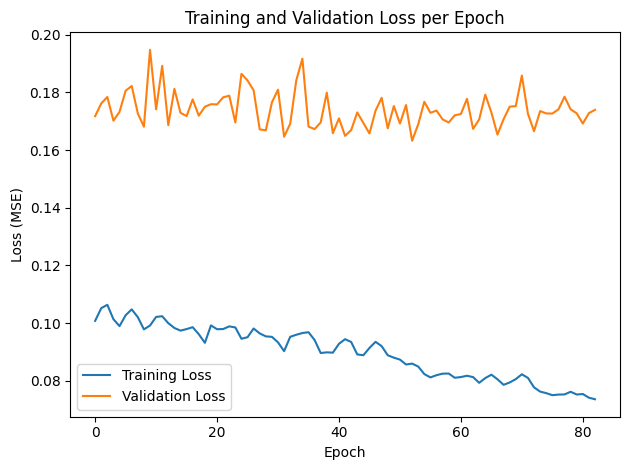

In [ ]:
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.title('Training and Validation Loss per Epoch')
  plt.grid(False)
  plt.legend()
  plt.tight_layout()
  plt.show()

  np.save("/content/drive/MyDrive/train_losses.npy", np.array(train_losses))
  np.save("/content/drive/MyDrive/val_losses.npy", np.array(val_losses))

/content/drive/MyDrive/efficientSCI_finetuned_band1.pth


Evaluating: 100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


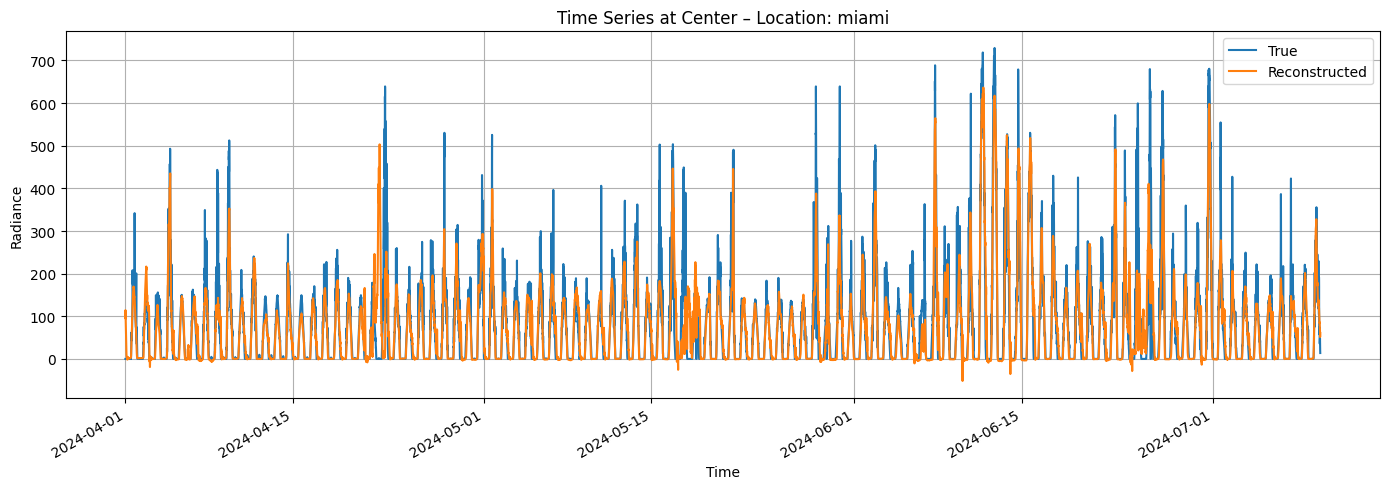

Average MSE: 2310.952711
Average PSNR: 24.96 dB


In [ ]:

if do_eval:
    print(model_ckpt_path)
    model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))
    model.eval()

    recon_ts_all, true_ts_all, mse_losses, psnr_scores = [], [], [], []

    with torch.no_grad():
        for y, phi, phi_s, x_true, max_val in tqdm(test_loader, desc="Evaluating", total=len(test_loader)):
            y, phi, phi_s, x_true = y.to(device), phi.to(device), phi_s.to(device), x_true.to(device)
            x_pred = model(y, phi, phi_s)[0]#.cpu()
            x_true = x_true#.cpu()
            max_val = max_val#.cpu()

            x_pred = torch.expm1(x_pred) * max_val.to(device) # invert log1p and rescale
            x_true = torch.expm1(x_true) * max_val.to(device)

            #Calculate MSE
            loss = nn.functional.mse_loss(x_pred, x_true).item()
            mse_losses.append(loss)

            #Calculate PSNR
            max_val_scalar = torch.max(x_true).item()  # or use a fixed value if needed
            psnr = 10 * np.log10((max_val_scalar ** 2) / (loss + 1e-8))
            psnr_scores.append(psnr)
            torch.cuda.empty_cache()
            gc.collect()

            T, H, W = x_true.shape[1:]
            h, w = H // 2, W // 2
            true_ts_all.append(x_true[0, :, h, w].cpu().numpy())
            recon_ts_all.append(x_pred[0, :, h, w].cpu().numpy())

    # Plot
    true_ts_concat = np.concatenate(true_ts_all)
    recon_ts_concat = np.concatenate(recon_ts_all)

    from datetime import datetime, timedelta
    start_time = datetime(2024, 4, 1)
    frame_times = [start_time + timedelta(minutes=10 * i) for i in range(len(true_ts_concat))]

    plt.figure(figsize=(14, 5))
    plt.plot(frame_times, true_ts_concat, label="True")
    plt.plot(frame_times, recon_ts_concat, label="Reconstructed", linestyle='-')
    plt.title(f"Time Series at Center – Location: {test_loc}")
    plt.xlabel('Time')
    plt.ylabel('Radiance')
    plt.grid()
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    print(f"Average MSE: {np.mean(mse_losses):.6f}")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")

